# Analyze and visualize last.fm listening history

To see this analysis live, check out my article ["Analyzing Last.fm Listening History"](http://geoffboeing.com/2016/05/analyzing-lastfm-history/)

The csv data files were created with [lastfm_downloader.ipynb](lastfm_downloader.ipynb)

In [1]:
import pandas as pd, numpy as np, string, re, pytz
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from datetime import datetime as dt
%matplotlib inline

In [2]:
# define the fonts to use for plots
family = 'DejaVu Sans'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=12, weight='normal', stretch='normal')
ticks_font_h = fm.FontProperties(family=family, style='normal', size=10.5, weight='normal', stretch='normal')

In [3]:
def get_colors(cmap, n, start=0., stop=1., alpha=1., reverse=False):
    '''return n-length list of rgba colors from the passed colormap name and alpha,
       limit extent by start/stop values and reverse list order if flag is true'''
    import matplotlib.cm as cm, numpy as np
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return list(reversed(colors)) if reverse else colors

## Top artists

In [4]:
artists_most = pd.read_csv('data/lastfm_top_artists.csv', encoding='utf-8')
artists_most = artists_most.set_index('artist')['play_count'].head(25)
artists_most.head()

artist
A.R. Rahman             1241
Coldplay                 865
Zero 7                   678
Two Door Cinema Club     572
Clint Mansell            430
Name: play_count, dtype: int64

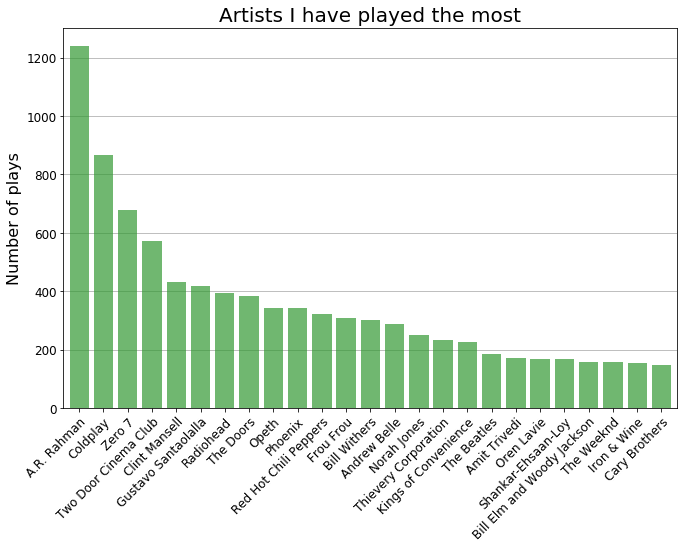

In [5]:
ax = artists_most.plot(kind='bar', figsize=[11, 7], width=0.8, alpha=0.7, color='#339933', edgecolor=None, zorder=2)

ax.yaxis.grid(True)
ax.set_xticklabels(artists_most.index, rotation=45, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Artists I have played the most', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Number of plays', fontproperties=label_font)

plt.savefig('images/lastfm-artists-played-most.png', dpi=96, bbox_inches='tight')
plt.show()

## Top tracks

In [6]:
tracks_most = pd.read_csv('data/lastfm_top_tracks.csv', encoding='utf-8')

def make_label(row, maxlength=30, suffix='...'):
    artist = row['artist']
    track = row['track']
    if len(track) > maxlength:
        track = '{}{}'.format(track[:maxlength-len(suffix)], suffix)
    return '{}\n{}'.format(artist, track)

index = tracks_most.apply(make_label, axis='columns')
tracks_most = tracks_most.set_index(index).drop(labels=['artist', 'track'], axis='columns')
tracks_most = tracks_most['play_count'].head(20)
tracks_most.head()

Zero 7\nIn the Waiting Line                633
Bill Withers\nAin't No Sunshine            303
Frou Frou\nLet Go                          279
Andrew Belle\nAll Those Pretty Lights      237
Clint Mansell\nDeath Is the Road to Awe    190
Name: play_count, dtype: int64

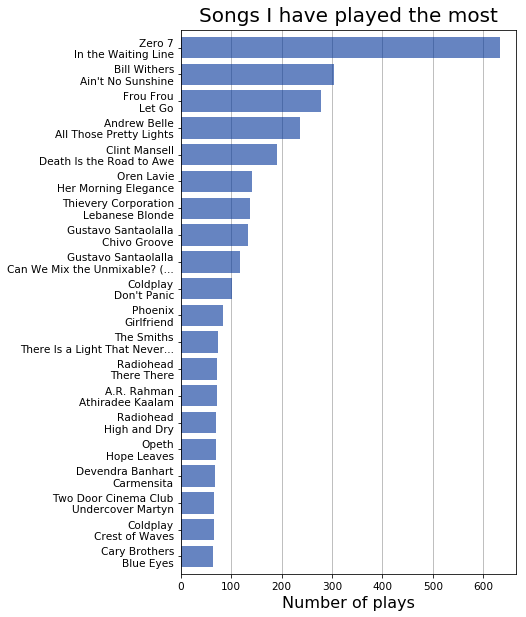

In [7]:
ax = tracks_most.sort_values().plot(kind='barh', figsize=[6, 10], width=0.8, alpha=0.6, 
                                    color='#003399', edgecolor=None, zorder=2)
ax.xaxis.grid(True)
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font_h)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font_h)
ax.set_xlabel('Number of plays', fontproperties=label_font)
ax.set_ylabel('', fontproperties=label_font)
ax.set_title('Songs I have played the most', fontproperties=title_font, y=1.005)

plt.savefig('images/lastfm-tracks-played-most-h.png', dpi=96, bbox_inches='tight')
plt.show()

## Top albums

In [8]:
albums_most = pd.read_csv('data/lastfm_top_albums.csv', encoding='utf-8')

def make_label(row, maxlength=25, suffix='...'):
    artist = row['artist']
    track = row['album']
    if len(track) > maxlength:
        track = '{}{}'.format(track[:maxlength-len(suffix)], suffix)
    return '{}\n{}'.format(artist, track)

index = albums_most.apply(make_label, axis='columns')
albums_most = albums_most.set_index(index).drop(labels=['artist', 'album'], axis='columns')
albums_most = albums_most['play_count'].head(30)
albums_most.head()

The Doors\nThe Very Best of The D...       301
Bill Withers\nNotting Hill OST             300
Red Hot Chili Peppers\nStadium Arcadium    292
Clint Mansell\nThe Fountain                286
Phoenix\nWolfgang Amadeus Phoenix          246
Name: play_count, dtype: int64

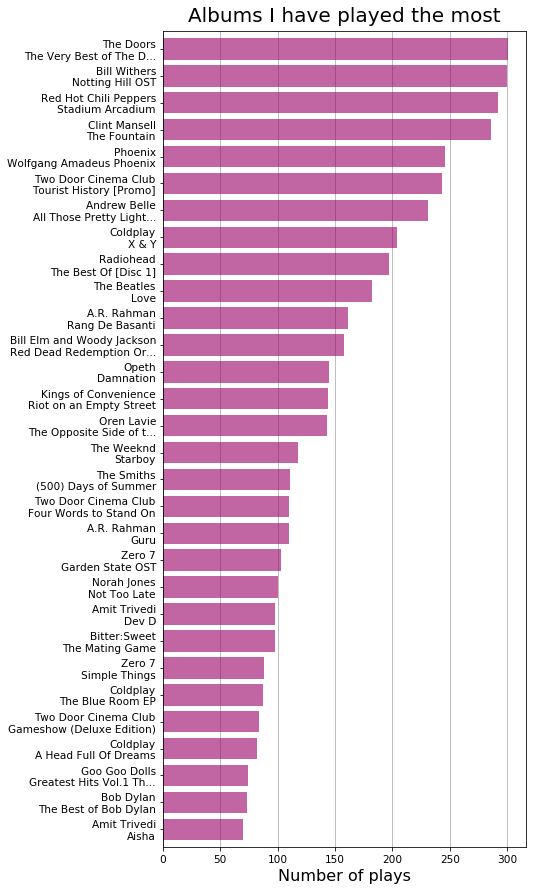

In [9]:
ax = albums_most.sort_values().plot(kind='barh', figsize=[6.5, 15], width=0.8, alpha=0.6, color='#990066', 
                                    edgecolor=None, zorder=2)
ax.xaxis.grid(True)
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font_h)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font_h)
ax.set_xlabel('Number of plays', fontproperties=label_font)
ax.set_ylabel('', fontproperties=label_font)
ax.set_title('Albums I have played the most', fontproperties=title_font, y=1.005)

plt.savefig('images/lastfm-albums-played-most-h.png', dpi=96, bbox_inches='tight')
plt.show()

## All-time scrobbles

In [10]:
# read the all-time scrobbles data set
scrobbles = pd.read_csv('data/lastfm_scrobbles.csv', encoding='utf-8')
scrobbles = scrobbles.drop('timestamp', axis=1)
print('{:,} total scrobbles'.format(len(scrobbles)))
print('{:,} total artists'.format(len(scrobbles['artist'].unique())))

15,927 total scrobbles
2,735 total artists


According to the last.fm web site, I have ~300,000 scrobbles. This API endpoint seems to miss the ones from before 2007.

In [11]:
# convert to datetime
scrobbles['timestamp'] = pd.to_datetime(scrobbles['datetime'])

In [12]:
# functions to convert UTC to Pacific time zone and extract date/time elements
convert_tz = lambda x: x.to_pydatetime().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('US/Pacific'))
get_year = lambda x: convert_tz(x).year
get_month = lambda x: '{}-{:02}'.format(convert_tz(x).year, convert_tz(x).month) #inefficient
get_day = lambda x: convert_tz(x).day
get_hour = lambda x: convert_tz(x).hour
get_day_of_week = lambda x: convert_tz(x).weekday()

These lambda functions are inefficient, but necessary to workaround this bug: https://github.com/pydata/pandas/issues/11757. I can update them when the bug is fixed in a future pandas version.

In [13]:
# parse out date and time elements as pacific time
scrobbles['year'] = scrobbles['timestamp'].map(get_year)
scrobbles['month'] = scrobbles['timestamp'].map(get_month)
scrobbles['day'] = scrobbles['timestamp'].map(get_day)
scrobbles['hour'] = scrobbles['timestamp'].map(get_hour)
scrobbles['dow'] = scrobbles['timestamp'].map(get_day_of_week)
scrobbles = scrobbles.drop(labels=['datetime'], axis=1)

# drop rows with 01-01-1970 as timestamp
scrobbles = scrobbles[scrobbles['year'] > 1970]
scrobbles.head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
0,Wildcat! Wildcat!,5cbb7d26-9fcb-40af-9b8a-c27e817a65a6,No Moon At All,3baab120-9640-4ea2-b3a3-63fd57c315c3,Sentimental,004673e7-05dd-444d-ace4-68be01cbe937,2018-01-20 11:02:39,2018,2018-01,20,3,5
1,Blackbird Blackbird,46e32991-1e7b-4575-9206-8e6519c97c14,Summer Heart,97c3ab39-fc2d-4596-a1d0-5690cc80c253,Hawaii,50e6dad8-1efd-4c96-b370-6a2a50b69df3,2018-01-20 11:00:00,2018,2018-01,20,3,5
2,High Highs,523fea33-ccf6-4a97-b3a5-5c4bc6d8c8ee,Cascades,NaN,Fastnet,NaN,2018-01-20 10:56:51,2018,2018-01,20,2,5
3,Niranjana Ramanan,NaN,Agnyaathavaasi (Original Motion Picture Soundt...,NaN,Swagatham Krishna,NaN,2018-01-20 10:52:08,2018,2018-01,20,2,5
4,Anirudh Ravichander,cf76861a-c1f5-456d-8d17-5994d05eecf8,Agnyaathavaasi (Original Motion Picture Soundt...,NaN,Dhaga Dhagamaney,NaN,2018-01-20 10:48:19,2018,2018-01,20,2,5


All the last.fm timestamps of my scrobbles appear to be UTC, but the year, month, day, hour columns are now converted to Pacific Time (where I've done nearly all my listening)

## Year-by-year analysis

Visualize the number of scrobbles per year

In [14]:
year_counts = scrobbles['year'].value_counts().sort_index()

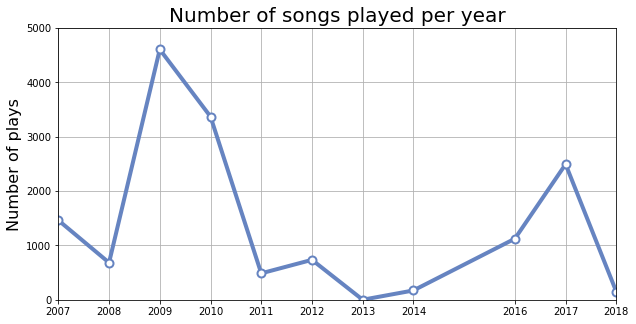

In [21]:
year_counts = scrobbles['year'].value_counts().sort_index()
ax = year_counts.plot(kind='line', figsize=[10, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.set_xlim((year_counts.index[0], year_counts.index[-1]))

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylim(0, 5000)
ax.set_xticks(year_counts.index)
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per year', fontproperties=title_font)

plt.savefig('images/lastfm-scrobbles-per-year.png', dpi=96, bbox_inches='tight')
plt.show()

## Month-by-month analysis

Visualize the number of scrobbles per month from 2010 through the present day

In [16]:
# get all the scrobbles from 2010-present
min_year = 2010
scrobbles_10 = scrobbles[scrobbles['year'] >= min_year]
max_year = max(scrobbles_10['year'])

In [17]:
# count number of scrobbles in each month
month_counts = scrobbles_10['month'].value_counts().sort_index()

# not every month necessarily has a scrobble, so fill in missing months with zero counts
date_range = pd.date_range(start=min(scrobbles_10['timestamp']), end=max(scrobbles_10['timestamp']), freq='D')
months_range = date_range.map(lambda x: str(x.date())[:-3])
index = np.unique(months_range)
month_counts = month_counts.reindex(index, fill_value=0)

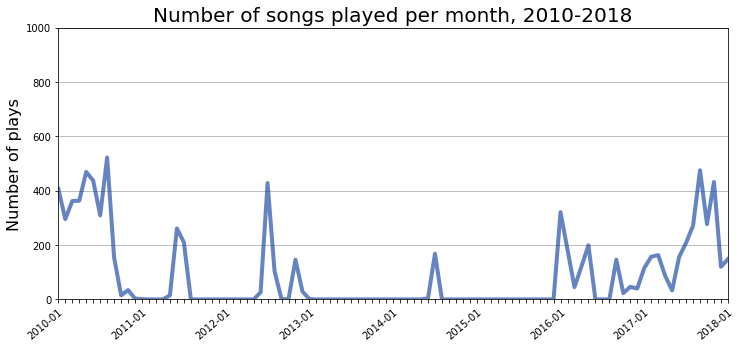

In [19]:
ax = month_counts.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=0.6, color='#003399')

xlabels = month_counts.iloc[range(0, len(month_counts), 12)].index
xlabels = [x if x in xlabels else '' for x in month_counts.index]
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=40, rotation_mode='anchor', ha='right')

ax.set_xlim((0, len(month_counts)-1))

ax.yaxis.grid(True)
ax.set_ylim((0,1000))
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per month, {}-{}'.format(min_year, max_year), fontproperties=title_font)

plt.savefig('images/lastfm-scrobbles-per-month.png', dpi=96, bbox_inches='tight')
plt.show()

## Day of the week analysis

How many songs have been played on each day of the week?

In [22]:
# get the play count sum by day of the week
dow_counts = scrobbles['dow'].value_counts().sort_index()
dow_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

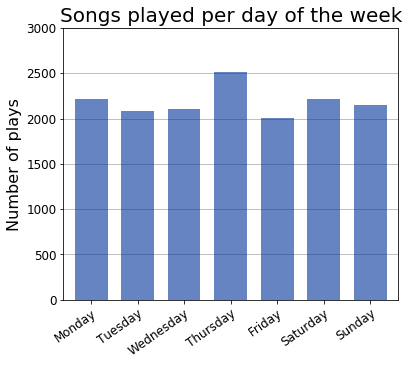

In [27]:
ax = dow_counts.plot(kind='bar', figsize=[6, 5], width=0.7, alpha=0.6, color='#003399', edgecolor=None, zorder=2)

ax.yaxis.grid(True)
ax.set_xticklabels(dow_counts.index, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_ylim((0, 3000))
ax.set_title('Songs played per day of the week', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Number of plays', fontproperties=label_font)

plt.savefig('images/lastfm-scrobbles-per-weekday.png', dpi=96, bbox_inches='tight')
plt.show()

## Hour of the day analysis

How many songs have been played during each hour of the day?

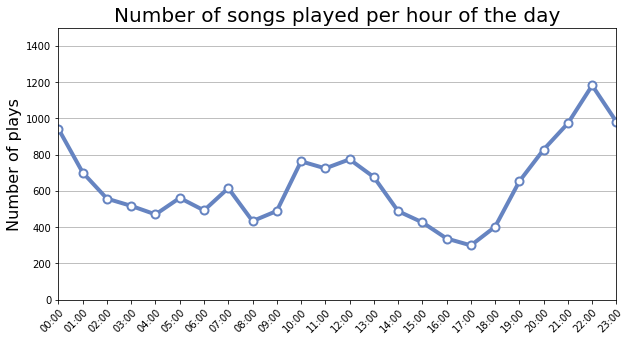

In [31]:
hour_counts = scrobbles['hour'].value_counts().sort_index()
ax = hour_counts.plot(kind='line', figsize=[10, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

xlabels = hour_counts.index.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.set_xlim((hour_counts.index[0], hour_counts.index[-1]))

ax.yaxis.grid(True)
ax.set_ylim((0, 1500))
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per hour of the day', fontproperties=title_font)

plt.savefig('images/lastfm-scrobbles-per-hour.png', dpi=96, bbox_inches='tight')
plt.show()

## Analysis by day of the week + hour of the day

How many songs have been played during each hour of the day on each day of the week?

In [32]:
# get the play counts by hour of day and day of week
weekday_hour_counts = scrobbles.groupby(['dow','hour']).count()['track']
hour_numbers = weekday_hour_counts.index.levels[1]
day_numbers = weekday_hour_counts.index.levels[0]
day_names = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

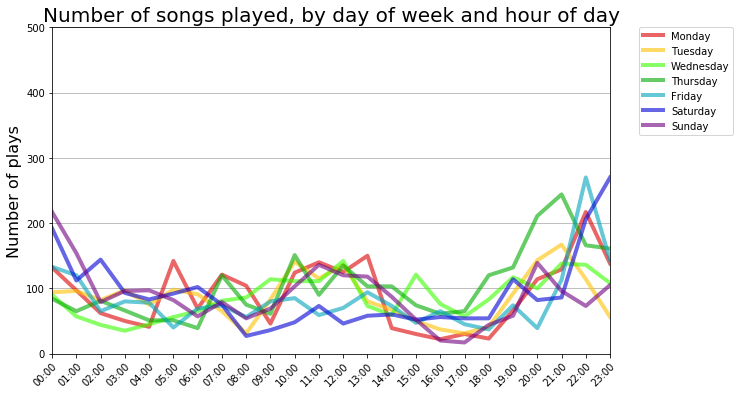

In [35]:
# get one color per day of week
colors = get_colors('nipy_spectral_r', n=len(day_numbers), start=0.1, stop=0.95)

fig, ax = plt.subplots(figsize=[10, 6])
lines = []
for day, c in zip(day_numbers, colors):
    ax = weekday_hour_counts[day].plot(kind='line', linewidth=4, alpha=0.6, c=c)
    lines.append(day_names[day])
    
xlabels = hour_numbers.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.set_xlim((hour_numbers[0], hour_numbers[-1]))

ax.yaxis.grid(True)
ax.set_ylim([0, 500])
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played, by day of week and hour of day', fontproperties=title_font)
ax.legend(lines, loc='upper right', bbox_to_anchor=(1.23,1.017))

plt.savefig('images/lastfm-scrobbles-days-hours.png', dpi=96, bbox_inches='tight')
plt.show()

## Analysis of a single year (or multiple years)

Add additional years to the 'isin' list to query multiple years.

In [43]:
scrobbles_year = scrobbles[scrobbles['year'].isin([2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018])]
len(scrobbles_year)

15283

In [44]:
# what artists did i play the most that year?
artists_year = scrobbles_year['artist'].value_counts()
artists_year = pd.DataFrame(artists_year).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_year.index = [n + 1 for n in artists_year.index]
artists_year.head(10)

,artist,play count
1,Two Door Cinema Club,572
2,Radiohead,394
3,Phoenix,341
4,Coldplay,323
5,Opeth,303
6,Bill Withers,300
7,Andrew Belle,288
8,Zero 7,240
9,Kings of Convenience,226
10,The Doors,219


In [45]:
# what tracks did i play the most that year?
tracks_year = scrobbles_year.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_year = tracks_year.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_year.index = [n + 1 for n in tracks_year.index]
tracks_year.head(10)

,artist,track,play count
1,Bill Withers,Ain't No Sunshine,300
2,Andrew Belle,All Those Pretty Lights,237
3,Zero 7,In the Waiting Line,195
4,Oren Lavie,Her Morning Elegance,141
5,Thievery Corporation,Lebanese Blonde,85
6,Phoenix,Girlfriend,83
7,The Smiths,There Is a Light That Never Goes Out,73
8,Radiohead,There There,72
9,Radiohead,High and Dry,69
10,Opeth,Hope Leaves,69


In [46]:
# what albums did i play the most that year?
albums_year = scrobbles_year.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_year = albums_year.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_year.index = [n + 1 for n in albums_year.index]

# remove text in parentheses or brackets
regex = re.compile('\\(.*\\)|\\[.*]')
albums_year['album'] = albums_year['album'].map(lambda x: regex.sub('', x))
albums_year.head(10)

,artist,album,play count
1,Bill Withers,Notting Hill OST,300
2,Phoenix,Wolfgang Amadeus Phoenix,246
3,Two Door Cinema Club,Tourist History,243
4,Andrew Belle,All Those Pretty Lights EP,231
5,Radiohead,The Best Of,197
6,Bill Elm and Woody Jackson,Red Dead Redemption Original Soundtrack,158
7,Opeth,Damnation,145
8,Kings of Convenience,Riot on an Empty Street,144
9,Oren Lavie,The Opposite Side of the Sea,143
10,The Doors,The Very Best of The Doors,136


## Analysis of a single month (or multiple months)

Add additional months to the 'isin' list to query multiple months.

In [49]:
scrobbles_month = scrobbles[scrobbles['month'].isin(['2009-02'])]
len(scrobbles_month)

62

In [50]:
# what artists did i play the most that month?
artists_month = scrobbles_month['artist'].value_counts()
artists_month = pd.DataFrame(artists_month).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_month.index = [n + 1 for n in artists_month.index]
artists_month.head(10)

,artist,play count
1,Thievery Corporation,14
2,Radiohead,9
3,Kings of Convenience,6
4,Zero 7,6
5,Sondre Lerche,4
6,Opeth,3
7,The Doors,3
8,Frou Frou,2
9,Devendra Banhart,2
10,Ash King & Chinmayee,1


In [51]:
# what tracks did i play the most that month?
tracks_month = scrobbles_month.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_month = tracks_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_month.index = [n + 1 for n in tracks_month.index]
tracks_month.head(10)

,artist,track,play count
1,Zero 7,In the Waiting Line,6
2,The Doors,Waiting for the Sun,3
3,Thievery Corporation,Lebanese Blonde,3
4,Frou Frou,Let Go,2
5,Thievery Corporation,Marching The Hate Machines Into The Sun (Feat ...,2
6,Thievery Corporation,Liberation Front,2
7,Thievery Corporation,The Forgotten People,1
8,Sondre Lerche,Modern Nature,1
9,Radiohead,Kid A,1
10,Radiohead,Knives Out,1


In [52]:
# what albums did i play the most that month?
albums_month = scrobbles_month.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_month = albums_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_month.index = [n + 1 for n in albums_month.index]
albums_month.head(10)

,artist,album,play count
1,Kings of Convenience,Riot on an Empty Street,6
2,Zero 7,Garden State OST,6
3,Opeth,Blackwater Park,3
4,The Doors,The Very Best of The Doors,3
5,Sondre Lerche,Two Way Monologue,3
6,Frou Frou,Garden State OST,2
7,Radiohead,The Best Of [Disc 1],2
8,Coldplay,Garden State OST,1
9,Thievery Corporation,Garden State OST,1
10,Sondre Lerche,Faces Down,1


## Listening history of a specific artist, album, or track

See the last 5 times I've listened to someone or something

In [53]:
# when were the last 5 times I played something by My Bloody Valentine?
scrobbles[scrobbles['artist'].str.contains('My Bloody Valentine')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
8569,My Bloody Valentine,8ca01f46-53ac-4af2-8516-55a909c0905e,Loveless,4c2c07b9-792e-430a-902b-c4d8784d0bce,Sometimes,9839b527-a36d-4efb-8682-526601be5131,2009-12-26 12:53:01,2009,2009-12,26,4,5
9005,My Bloody Valentine,8ca01f46-53ac-4af2-8516-55a909c0905e,Loveless,4c2c07b9-792e-430a-902b-c4d8784d0bce,Sometimes,9839b527-a36d-4efb-8682-526601be5131,2009-11-30 03:58:30,2009,2009-11,29,19,6
11598,My Bloody Valentine,8ca01f46-53ac-4af2-8516-55a909c0905e,You Made Me Realise,cb88fab3-cfe4-353f-9946-746602d9583e,Cigarette in Your Bed,cbacac6a-ffa6-498a-8258-1ed891872e79,2009-06-11 16:20:03,2009,2009-06,11,9,3
13832,My Bloody Valentine,8ca01f46-53ac-4af2-8516-55a909c0905e,Live,NaN,Blow A Wish (Live),NaN,2007-12-30 17:07:36,2007,2007-12,30,9,6


In [57]:
# when were the last 5 times I played something off of Double Nickels on the Dime?
scrobbles[scrobbles['album'].fillna('').str.contains('Damnation')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
17,Opeth,c14b4180-dc87-481e-b17a-64e4150f90f6,Damnation,3fe02bae-ffbc-3a1f-82b7-d7b338f78b71,Weakness,bc3dee50-d6aa-4124-a688-97605673e686,2018-01-17 19:06:26,2018,2018-01,17,11,2
18,Opeth,c14b4180-dc87-481e-b17a-64e4150f90f6,Damnation,3fe02bae-ffbc-3a1f-82b7-d7b338f78b71,Ending Credits,a7035789-34d6-478d-acb6-a90bd2e5a711,2018-01-17 19:02:33,2018,2018-01,17,11,2
19,Opeth,c14b4180-dc87-481e-b17a-64e4150f90f6,Damnation,3fe02bae-ffbc-3a1f-82b7-d7b338f78b71,To Rid the Disease,23edb0d3-6a53-452a-8091-2339c10b8b1e,2018-01-17 18:57:22,2018,2018-01,17,10,2
20,Opeth,c14b4180-dc87-481e-b17a-64e4150f90f6,Damnation,3fe02bae-ffbc-3a1f-82b7-d7b338f78b71,Hope Leaves,2d68b55e-cc58-47eb-9f98-5442f73835c3,2018-01-17 18:52:02,2018,2018-01,17,10,2
21,Opeth,c14b4180-dc87-481e-b17a-64e4150f90f6,Damnation,3fe02bae-ffbc-3a1f-82b7-d7b338f78b71,Closure,2249c097-5bb7-4d8b-addc-1d36d99dbce9,2018-01-17 18:47:08,2018,2018-01,17,10,2


In [60]:
# when were the last 5 times I played Personality Crisis?
scrobbles[scrobbles['track'].str.contains('In the Waiting Line')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
309,Zero 7,c23b637b-97c6-41eb-8ef6-6c724efc80a8,Simple Things,492ba46b-0c4b-48c6-8dae-162058dc95e9,In the Waiting Line,0e6871fc-d16f-4cc8-86fc-c8d368f906d4,2017-11-26 09:57:43,2017,2017-11,26,1,6
1006,Zero 7,c23b637b-97c6-41eb-8ef6-6c724efc80a8,Simple Things,492ba46b-0c4b-48c6-8dae-162058dc95e9,In the Waiting Line,0e6871fc-d16f-4cc8-86fc-c8d368f906d4,2017-09-28 01:56:22,2017,2017-09,27,18,2
2139,Zero 7,c23b637b-97c6-41eb-8ef6-6c724efc80a8,Simple Things,492ba46b-0c4b-48c6-8dae-162058dc95e9,In the Waiting Line,0e6871fc-d16f-4cc8-86fc-c8d368f906d4,2017-04-05 05:36:27,2017,2017-04,4,22,1
2620,Zero 7,c23b637b-97c6-41eb-8ef6-6c724efc80a8,Simple Things,492ba46b-0c4b-48c6-8dae-162058dc95e9,In the Waiting Line,0e6871fc-d16f-4cc8-86fc-c8d368f906d4,2017-01-17 12:19:45,2017,2017-01,17,4,1
2865,Zero 7,c23b637b-97c6-41eb-8ef6-6c724efc80a8,Simple Things,492ba46b-0c4b-48c6-8dae-162058dc95e9,In the Waiting Line,0e6871fc-d16f-4cc8-86fc-c8d368f906d4,2016-09-09 07:40:59,2016,2016-09,9,0,4


## Visualize top artists over time

How have the cumulative plays of most listened-to artists changed over time?

In [61]:
# get the cumulative play counts since 2009 for the top n most listened-to artists
n = 6
plays = scrobbles[scrobbles['artist'].isin(artists_most.head(n).index)]
plays = plays[plays['year'] >= 2009]
plays = plays.groupby(['artist','year']).count().groupby(level=[0]).cumsum()['track']

# make sure we have each year represented for each artist, even if they got no plays that year
plays = plays.unstack().T.fillna(method='ffill').T.stack()
top_artists = plays.index.levels[0]

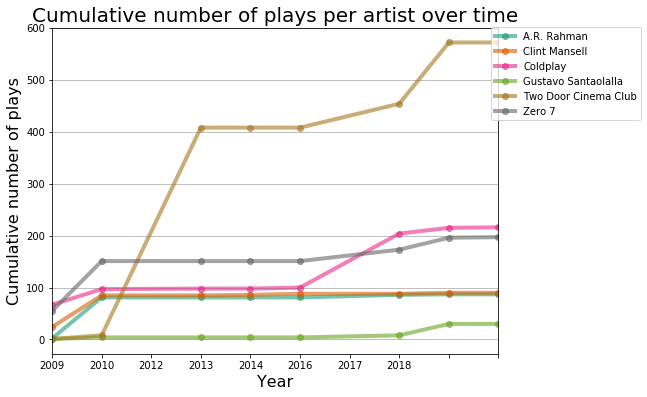

In [62]:
# get one color per artist
colors = get_colors('Dark2', n)

fig, ax = plt.subplots(figsize=[8, 6])
lines = []
for artist, c in zip(top_artists, colors):
    ax = plays[artist].plot(kind='line', linewidth=4, alpha=0.6, marker='o', c=c)
    lines.append(artist)
    
ax.set_xlim((plays.index.get_level_values(1).min(), plays.index.get_level_values(1).max()))

ax.yaxis.grid(True)
ax.set_xticklabels(plays.index.levels[1], rotation=0, rotation_mode='anchor', ha='center')
ax.set_ylabel('Cumulative number of plays', fontproperties=label_font)
ax.set_xlabel('Year', fontproperties=label_font)
ax.set_title('Cumulative number of plays per artist over time', fontproperties=title_font)
ax.legend(lines, loc='upper right', bbox_to_anchor=(1.33, 1.016))

plt.savefig('images/lastfm-scrobbles-top-artists-years.png', dpi=96, bbox_inches='tight')
plt.show()

## Characteristics of artists' names

Text analysis of artist name strings

In [63]:
# remove 'The ' and 'A ' preceding artist names, get unique set of names, then get first letter frequency
artists_clean = scrobbles['artist'].str.replace('The ','').str.replace('A ','')
first_letters = pd.Series(artists_clean.unique()).map(lambda x: x.upper()[0]).value_counts()
first_letters = first_letters[[c for c in string.ascii_uppercase]]

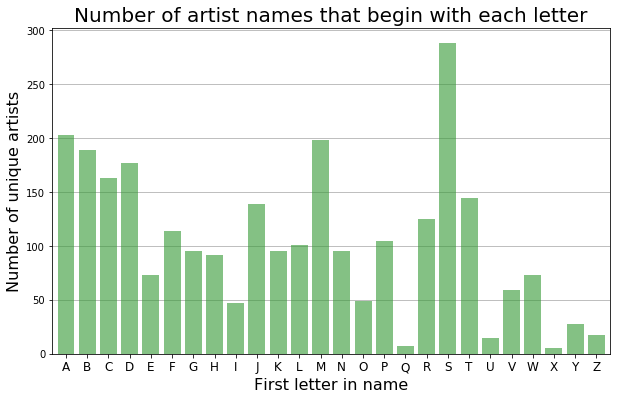

In [64]:
# plot the frequency of artist names that begin with each letter
ax = first_letters.plot(kind='bar', figsize=[10, 6], width=0.8, alpha=0.6, color='#339933', edgecolor=None, zorder=2)
ax.yaxis.grid(True)
ax.set_xticklabels(first_letters.index, rotation=0, rotation_mode='anchor', ha='center', fontproperties=ticks_font)

ax.set_title('Number of artist names that begin with each letter', fontproperties=title_font)
ax.set_xlabel('First letter in name', fontproperties=label_font)
ax.set_ylabel('Number of unique artists', fontproperties=label_font)

plt.savefig('images/lastfm-artists-first-letter-count.png', dpi=96, bbox_inches='tight')
plt.show()

In [65]:
# which artist names begin with the letter 'X'?
str(list(pd.Series(artists_clean[artists_clean.str.upper().str.startswith('X')].unique())))

"['xx', 'Xplor', 'X.Y.R.', 'X Ambassadors', 'Xiu Xiu']"

In [66]:
# what are the most common first words in artist names that begin with 'M'?
artists_m = pd.Series(artists_clean[artists_clean.str.upper().str.startswith('M')].unique())
artists_m.map(lambda x: x.split()[0]).value_counts().head(15)

Matt        7
My          4
Matthew     4
Max         3
Michael     3
Mickey      3
Major       3
M.          3
Music       2
Martin      2
Michelle    2
Morning     2
Midnight    2
Miles       2
Meg         2
dtype: int64

In [67]:
# what are the most common first words in all the artist names?
pd.Series(scrobbles['artist'].unique()).map(lambda x: x.split()[0].lower()).value_counts().head(15)

the       222
a.         22
black       8
andrew      7
joe         7
ben         7
a           7
matt        7
amit        6
dan         6
white       6
vishal      6
arijit      6
dead        6
dj          6
dtype: int64

In [42]:
# what are the most common words in all the artist names, anywhere in the name?
word_list = []
stop_list = ['&','the','and','of','a','in','for','la','los','el','de','y']
for artist in artists_clean.unique():
    for word in artist.split():
        word_list.append(word.lower())

word_list = [word for word in word_list if word not in stop_list]
pd.Series(word_list).value_counts().head(15)

band         302
orchestra    219
dj           145
john         136
ensemble     132
trio         132
his          128
black        106
david        102
james         86
brothers      80
paul          75
quartet       73
music         72
new           70
dtype: int64

In [43]:
# what is the longest artist name?
print('"{}"'.format(max(artists_clean, key=len)))

"Adam Baldych, Baltic Gang, Lars Danielsson, Jacob Karlzon, Morten Lund, Verneri Pohjola & Marius Neset"


In [44]:
# what is the distribution of lengths of artist names (up to n number of characters)?
n = 50
name_lengths = pd.Series([len(artist) for artist in artists_clean.unique()])
name_lengths = name_lengths.value_counts().sort_index()
name_lengths = name_lengths.iloc[0:n+1].reindex(range(n+1), fill_value=0)

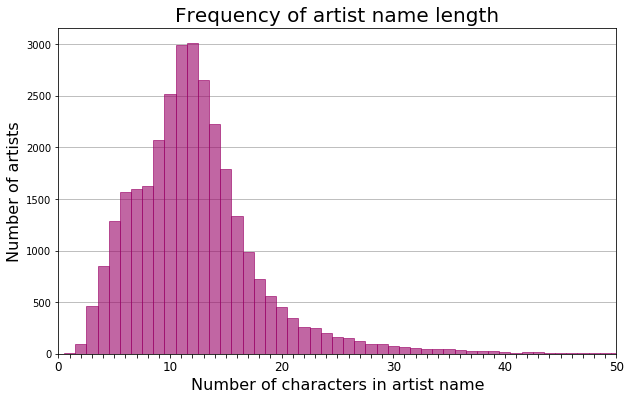

In [45]:
ax = name_lengths.plot(kind='bar', figsize=(10,6), alpha=0.6, width=1, color='#990066', edgecolor='#990066', zorder=2)

xlabels = [x if x % 10 == 0 else '' for x in name_lengths.index]
ax.set_xticklabels(xlabels, rotation=0, rotation_mode='anchor', ha='center', fontproperties=ticks_font)
ax.yaxis.grid(True)
ax.set_xlim((0,n))

ax.set_title('Frequency of artist name length', fontproperties=title_font)
ax.set_xlabel('Number of characters in artist name', fontproperties=label_font)
ax.set_ylabel('Number of artists', fontproperties=label_font)

plt.savefig('images/lastfm-artists-name-length.png', dpi=96, bbox_inches='tight')
plt.show()